In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import hvplot
import hvplot.pandas

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/DVN.csv')
data.set_index('Date',inplace=True)
data = data[['Close']]

In [3]:
data.head(10)

,Close
Date,
2015-02-17,66.650002
2015-02-18,63.950001
2015-02-19,64.410004
2015-02-20,63.820000
2015-02-23,63.950001
2015-02-24,64.839996
2015-02-25,65.449997
2015-02-26,62.549999
2015-02-27,61.590000


In [4]:
#apple.reset_index(inplace=True)
#mask = (apple['Date'] > '2010-04-16') & (apple['Date'] <= '2018-04-27')
#train = apple.loc[mask]
#mask2 = (apple['Date'] > '2018-04-27') 
#test = apple.loc[mask2]
#train.set_index('Date',inplace=True)
#test.set_index('Date',inplace=True)

In [5]:
#train = apple['2010-04-16':'2018-04-27']
#test  = apple['2018-04-27':]
#print('Train Dataset:',train.shape)
#print('Test Dataset:',test.shape)

In [6]:
data.reset_index(inplace=True)
train = data.loc[data['Date'] <= '2018-04-27']
test = data.loc[data['Date'] > '2018-04-27']
train.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)

In [7]:
train

,Close
Date,
2015-02-17,66.650002
2015-02-18,63.950001
2015-02-19,64.410004
2015-02-20,63.820000
2015-02-23,63.950001
...,...
2018-04-23,35.430000
2018-04-24,34.480000
2018-04-25,35.200001


In [8]:
test

,Close
Date,
2018-04-30,36.330002
2018-05-01,36.200001
2018-05-02,38.230000
2018-05-03,37.200001
2018-05-04,37.869999
...,...
2020-02-10,22.540001
2020-02-11,22.700001
2020-02-12,23.260000


In [9]:
#apple["Norm return"] = apple["Close"] / apple.iloc[0]["Close"]
#apple["Allocation"] = apple["Norm return"] * allocation
#apple["Position"] = apple["Allocation"]*4000

In [10]:
short_window = 10
long_window = 40

for stock_df in (test,train):
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    stock_df['fast_close'] = stock_df['Close'].ewm(halflife=short_window).mean()
    stock_df['slow_close'] = stock_df['Close'].ewm(halflife=long_window).mean()
    stock_df['Signal'] = 0.0


# Construct a crossover trading signal
    stock_df['Signal'][short_window:] = np.where(
    stock_df['fast_close'][short_window:] > stock_df['slow_close'][short_window:], 1.0, 0.0
    )
   
    stock_df['Entry/Exit'] = stock_df['Signal'].diff()

/Users/carlosysmayelalvarez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlosysmayelalvarez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/carlosysmayelalvarez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [11]:
fast_close = list(train['fast_close'])
slow_close = list(train['slow_close'])
price = list(train['Close'])

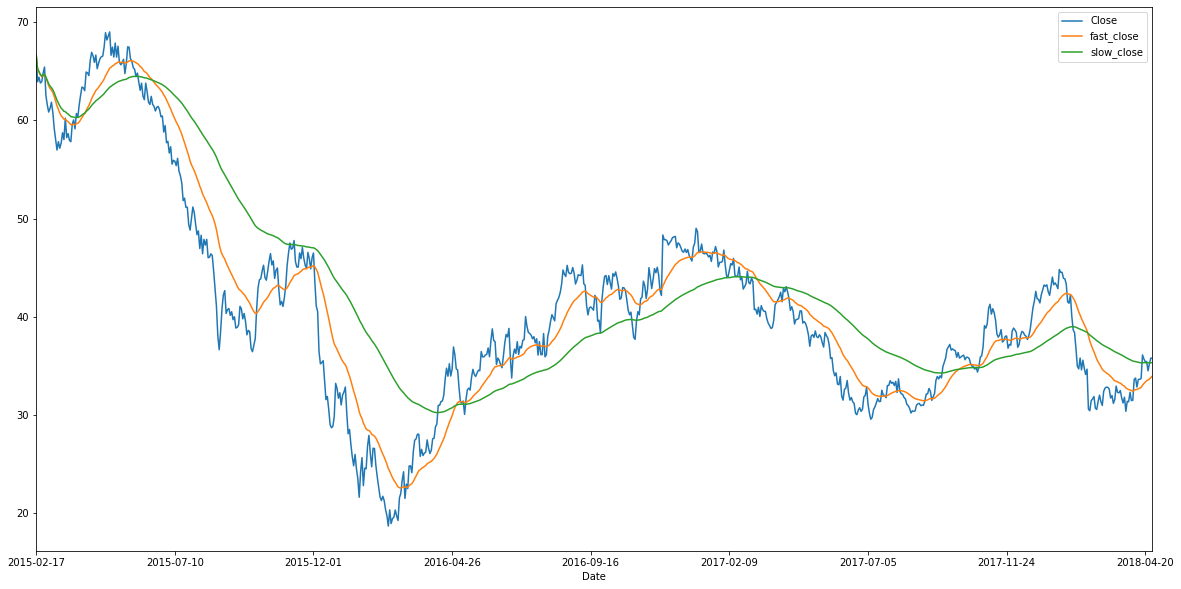

In [12]:
train[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [13]:
exit = train[train['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = train[train['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

security_close = train[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

moving_avgs = train[['slow_close', 'fast_close']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)


entry_exit_plot = moving_avgs*security_close * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test)

                Close  fast_close  slow_close  Signal  Entry/Exit
Date                                                             
2018-04-30  36.330002   36.330002   36.330002     0.0         NaN
2018-05-01  36.200001   36.262750   36.264438     0.0         0.0
2018-05-02  38.230000   36.964441   36.931011     0.0         0.0
2018-05-03  37.200001   37.029588   37.000017     0.0         0.0
2018-05-04  37.869999   37.221739   37.180095     0.0         0.0
2018-05-07  37.889999   37.353266   37.303597     0.0         0.0
2018-05-08  39.020000   37.643609   37.561726     0.0         0.0
2018-05-09  40.220001   38.048949   37.914509     0.0         0.0
2018-05-10  40.889999   38.458885   38.268494     0.0         0.0
2018-05-11  40.950001   38.792530   38.558033     0.0         0.0
2018-05-14  41.320000   39.109798   38.831435     1.0         1.0
2018-05-15  41.279999   39.367148   39.055485     1.0         0.0
2018-05-16  41.400002   39.596379   39.255173     1.0         0.0
2018-05-17

In [72]:
test.reset_index(inplace=True)
mask = (test['Date'] > '2020-01-23') & (test['Date'] <= '2020-01-31')
signal = test.loc[mask]
test.set_index('Date',inplace=True)

In [73]:
real4 = signal

In [120]:
real4

,Date,Close,fast_close,slow_close,Signal,Entry/Exit
437,2020-01-24,23.950001,24.981584,24.396163,1.0,0.0
438,2020-01-27,22.620001,24.823436,24.365635,1.0,0.0
439,2020-01-28,22.719999,24.682575,24.337350,1.0,0.0
440,2020-01-29,22.190001,24.515655,24.300442,1.0,0.0
441,2020-01-30,22.490000,24.380003,24.269325,1.0,0.0
442,2020-01-31,21.719999,24.201871,24.225509,0.0,-1.0


In [50]:
signal1
signal2
signal3
signal4
real1
real2
real3
real4

,Date,Close,fast_close,slow_close,Signal,Entry/Exit
414,2019-12-19,25.110001,23.029229,23.785774,0.0,0.0
415,2019-12-20,25.469999,23.192680,23.814729,0.0,0.0
416,2019-12-23,26.230000,23.396080,23.856252,0.0,0.0
417,2019-12-24,26.540001,23.606619,23.902390,0.0,0.0
418,2019-12-26,26.360001,23.791005,23.944640,0.0,0.0
419,2019-12-27,25.730000,23.920854,23.975333,0.0,0.0
420,2019-12-30,25.530001,24.028613,24.002059,1.0,1.0
421,2019-12-31,25.969999,24.158622,24.035890,1.0,0.0
422,2020-01-02,25.790001,24.267871,24.066044,1.0,0.0
423,2020-01-03,26.100000,24.390563,24.101009,1.0,0.0


In [53]:
signal1

,Date,Close,fast_close,slow_close,Signal,Entry/Exit
206,2019-02-25,29.490000,27.359682,30.002264,0.0,0.0
207,2019-02-26,29.590000,27.509040,29.994983,0.0,0.0
208,2019-02-27,29.879999,27.667816,29.992953,0.0,0.0
209,2019-02-28,29.510000,27.791182,29.984433,0.0,0.0
210,2019-03-01,30.150000,27.949145,29.987352,0.0,0.0
211,2019-03-04,29.440001,28.048983,29.977704,0.0,0.0
212,2019-03-05,29.270000,28.130751,29.965235,0.0,0.0
213,2019-03-06,28.719999,28.170211,29.943305,0.0,0.0
214,2019-03-07,28.059999,28.162830,29.910152,0.0,0.0
215,2019-03-08,26.709999,28.065539,29.853842,0.0,0.0


In [75]:
def fast_slow_list(signal_list):
    fast_list = list(signal_list['fast_close'])
    slow_list = list(signal_list['slow_close'])
    close_list = list(signal_list['Close'])
    return fast_list, slow_list

#Values used to predict:
fast1, slow1 = fast_slow_list(signal1)
fast2, slow2 = fast_slow_list(signal2)
fast3, slow3 = fast_slow_list(signal3)
fast4, slow4 = fast_slow_list(signal4)

#Real sequences to be compared with future predicted sequences:
fast1_real, slow1_real = fast_slow_list(real1)
fast2_real, slow2_real = fast_slow_list(real2)
fast3_real, slow3_real = fast_slow_list(real3)
fast4_real, slow4_real = fast_slow_list(real4)

In [96]:
fast1_real

[29.64740939217196,
 29.77548981087189,
 29.893653858870426,
 29.98180556361249,
 30.0305705040355,
 30.096159972909632]

In [20]:
def rnn_model(training_sequence):
    
    # split sequence
    def sequence_split(sequence, n_steps_in, n_steps_out):
        X, y = list(), list()
        for i in range(len(sequence)):
        # find end sequence
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            if out_end_ix > len(sequence):
                break
        # get features and targets
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)
 
    # sequence to train model on
    raw_seq = price
    # time steps
    n_steps_in, n_steps_out = 24, 6
    # get samples
    X, y = sequence_split(raw_seq, n_steps_in, n_steps_out)
    # reshape data to feed rnn
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit the model
    model.fit(X, y, epochs=500, verbose=0)
    return model

In [21]:
model_fast = rnn_model(fast_list)
model_slow = rnn_model(slow_list)

In [105]:
# make predictions

n_steps_in, n_steps_out = 24, 6
n_features = 1

def predict_sequence(past_sequence,model):
    temp_model = model
    x_input = array(past_sequence)
    x_input = x_input.reshape((1, n_steps_in, n_features))
    future = temp_model.predict(x_input, verbose=0)
    return future

fast1_predicted = predict_sequence(fast1,model_fast)
fast2_predicted = predict_sequence(fast2,model_fast)
fast3_predicted = predict_sequence(fast3,model_fast)
fast4_predicted = predict_sequence(fast4,model_fast)
slow1_predicted = predict_sequence(slow1,model_slow)
slow2_predicted = predict_sequence(slow2,model_slow)
slow3_predicted = predict_sequence(slow3,model_slow)
slow4_predicted = predict_sequence(slow4,model_slow)

In [106]:
fast1_predicted=fast1_predicted.tolist()
fast2_predicted=fast2_predicted.tolist()
fast3_predicted=fast3_predicted.tolist()
fast4_predicted=fast4_predicted.tolist()
slow1_predicted=slow1_predicted.tolist()
slow2_predicted=slow2_predicted.tolist()
slow3_predicted=slow3_predicted.tolist()
slow4_predicted=slow4_predicted.tolist()

In [107]:
fast1_predicted[0]

[30.343914031982422,
 31.06294822692871,
 31.640066146850586,
 32.246551513671875,
 33.052635192871094,
 32.671974182128906]

In [108]:
d1 = {'slow_real': slow1_real, 'slow_predicted': slow1_predicted[0], 'fast_real': fast1_real, 'fast_predicted': fast1_predicted[0]}
result_1_df = pd.DataFrame(data=d1)

d2 = {'slow_real': slow2_real, 'slow_predicted': slow2_predicted[0], 'fast_real': fast2_real, 'fast_predicted': fast2_predicted[0]}
result_2_df = pd.DataFrame(data=d2)

d3 = {'slow_real': slow3_real, 'slow_predicted': slow3_predicted[0], 'fast_real': fast3_real, 'fast_predicted': fast3_predicted[0]}
result_3_df = pd.DataFrame(data=d3)

d4 = {'slow_real': slow4_real, 'slow_predicted': slow4_predicted[0], 'fast_real': fast4_real, 'fast_predicted': fast4_predicted[0]}
result_4_df = pd.DataFrame(data=d4)

In [109]:
result_1_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,29.974827,31.487736,29.647409,30.343914
1,30.002566,31.355747,29.775490,31.062948
2,30.029461,31.647038,29.893654,31.640066
3,30.050106,32.061802,29.981806,32.246552
4,30.061643,32.127762,30.030571,33.052635
5,30.078217,32.349640,30.096160,32.671974


In [110]:
result_2_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,30.866044,32.070759,31.476596,31.353888
1,30.851536,31.890272,31.379722,31.678358
2,30.856194,32.089878,31.362329,31.769657
3,30.829373,32.408546,31.224891,31.923586
4,30.765908,32.430550,30.953347,32.420700
5,30.700431,32.598118,30.687933,32.215698


In [111]:
result_3_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,23.814729,24.936745,23.192680,23.722784
1,23.856252,25.277966,23.396080,23.919641
2,23.902390,25.517801,23.606619,24.624273
3,23.944640,26.400526,23.791005,25.689451
4,23.975333,26.131611,23.920854,26.802727
5,24.002059,26.199982,24.028613,27.197653


In [112]:
result_4_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,24.396163,27.040081,24.981584,25.374832
1,24.365635,27.422375,24.823436,25.636202
2,24.337350,27.741180,24.682575,26.437508
3,24.300442,28.988640,24.515655,27.321812
4,24.269325,28.780649,24.380003,28.377913
5,24.225509,29.367035,24.201871,28.569696


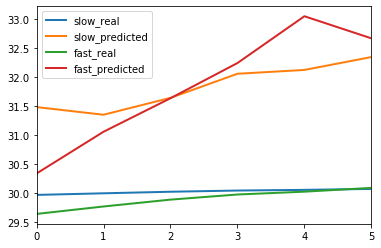

In [113]:
result_1_df.plot(lw=2);

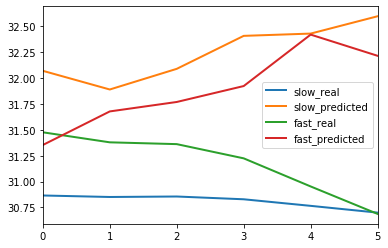

In [114]:
result_2_df.plot(lw=2);

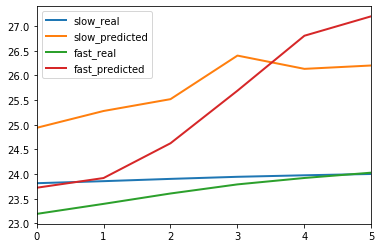

In [115]:
result_3_df.plot(lw=2);

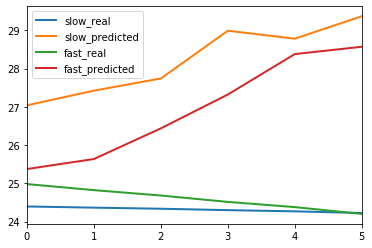

In [116]:
result_4_df.plot(lw=2);